<a href="https://colab.research.google.com/github/AsleepLeopard/pytorch/blob/main/cifar10_cnn_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [2]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:04<00:00, 34.4MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualize a Batch of Training Data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

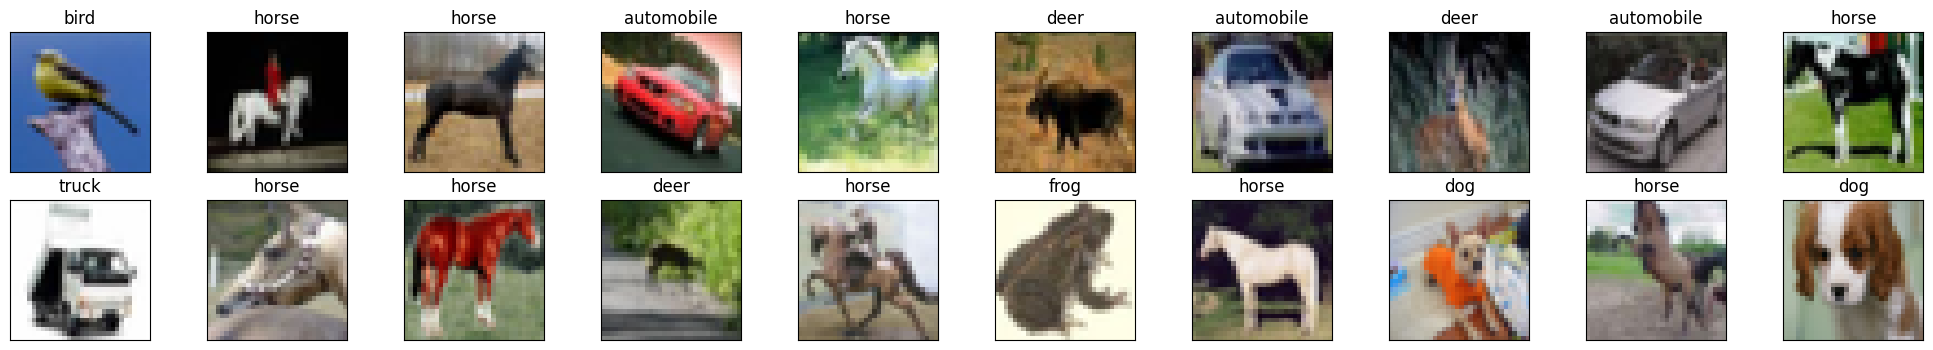

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
a = 20
b = 2
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(a/b), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

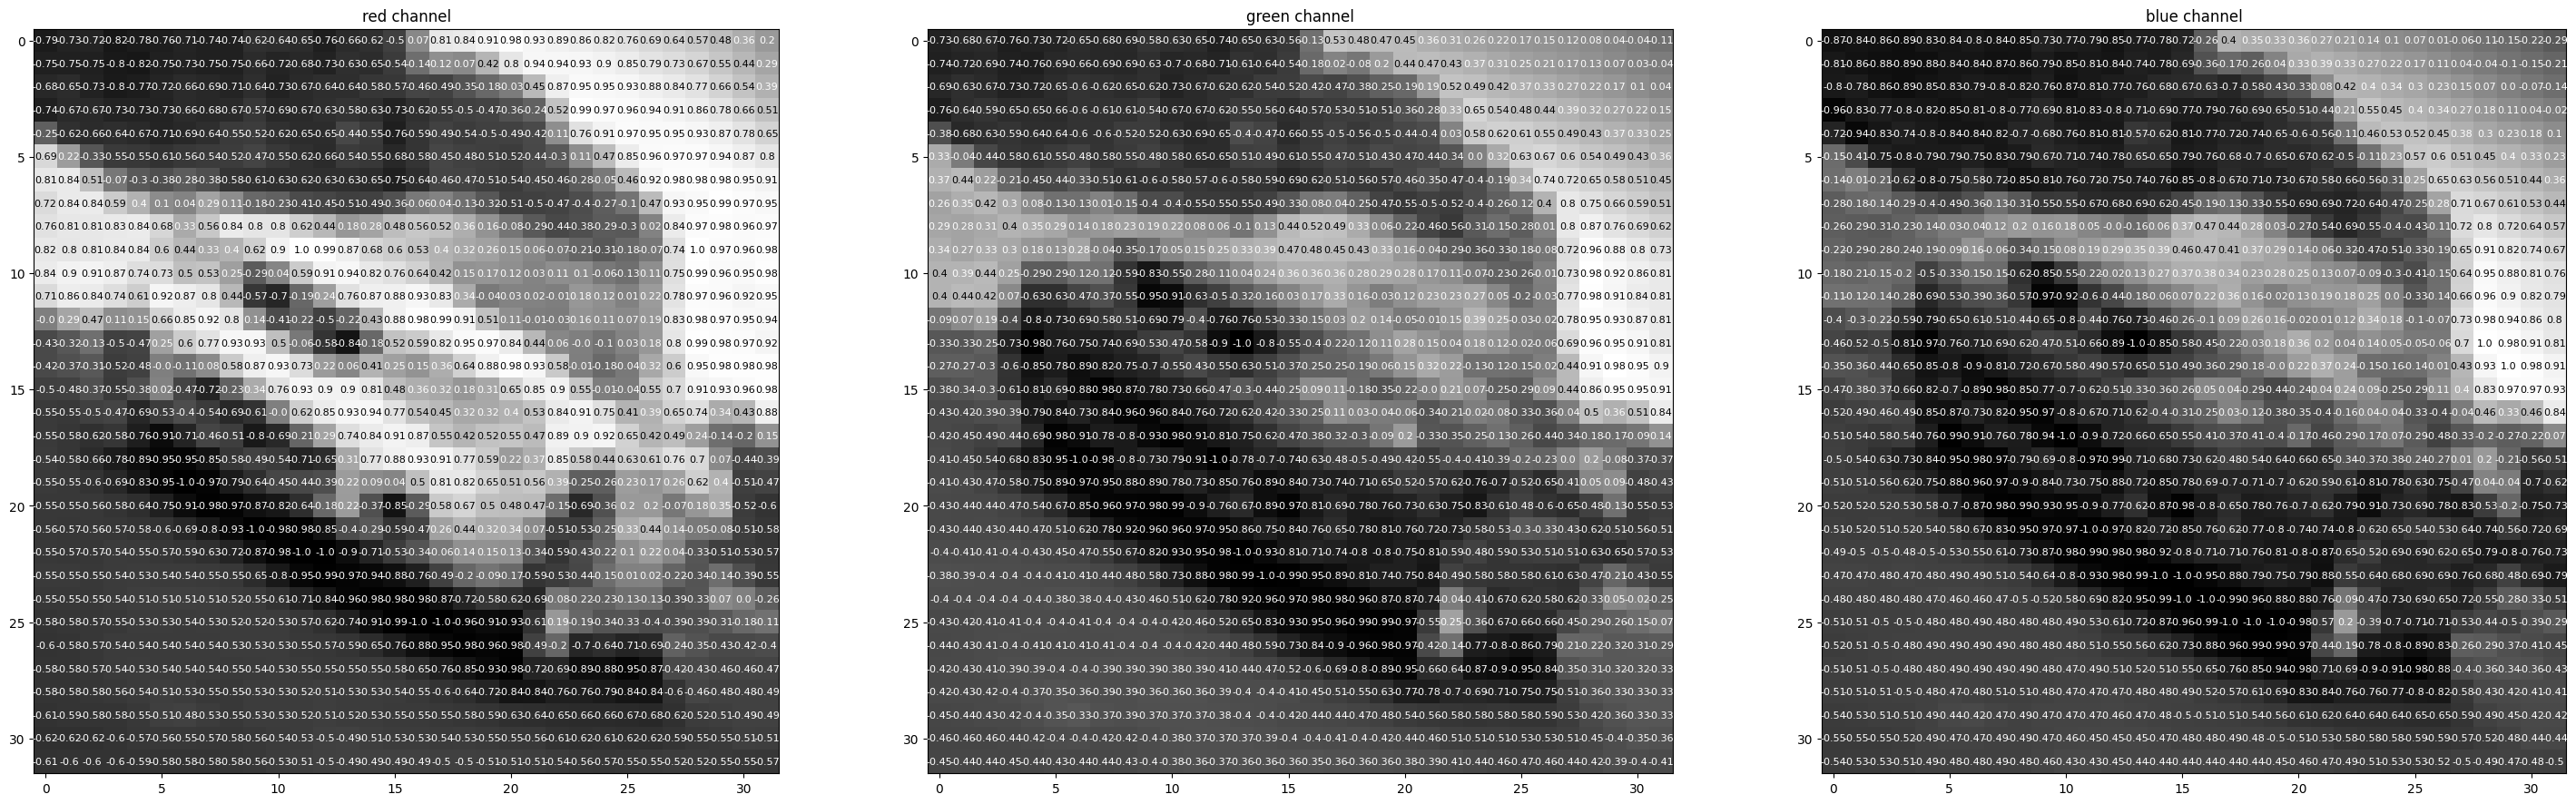

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='notebook_ims/2_layer_conv.png' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting.

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding = 1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layer
        self.fc1 = nn.Linear(16 * 4 * 4, 10)

        # Dropout
        self.dropout = nn.Dropout(p=0.2)

        # Output layer
        self.out = nn.LogSoftmax(dim = 1)

    def flatten(self, x):
        return x.view(x.size()[0], -1)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = self.dropout(self.pool(F.relu(self.conv3(x))))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.out(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): LogSoftmax(dim=1)
)


In [8]:
from torchsummary import summary

summary(model, input_size = images.shape[1:], batch_size = 20)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [20, 16, 32, 32]             448
         MaxPool2d-2           [20, 16, 16, 16]               0
           Dropout-3           [20, 16, 16, 16]               0
            Conv2d-4           [20, 32, 16, 16]           4,640
         MaxPool2d-5             [20, 32, 8, 8]               0
           Dropout-6             [20, 32, 8, 8]               0
            Conv2d-7             [20, 16, 8, 8]           4,624
         MaxPool2d-8             [20, 16, 4, 4]               0
           Dropout-9             [20, 16, 4, 4]               0
           Linear-10                   [20, 10]           2,570
       LogSoftmax-11                   [20, 10]               0
Total params: 12,282
Trainable params: 12,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.23
Forward/ba

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [9]:
import torch.optim as optim

# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters())

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [10]:
# number of epochs to train the model
n_epochs = 20 # you may increase this number to train a final model
epochs_no_improve = 0
max_epochs_stop = 3

save_file_name = 'model-cifar.pt'

valid_loss_min = np.Inf # track change in validation loss

def train(model, train_loader, valid_loader,
          n_epochs = 20, save_file = 'model-cifar.pt'):

    # specify loss function
    criterion = nn.NLLLoss()

    # specify optimizer
    optimizer = optim.Adam(model.parameters())

    epochs_no_improve = 0
    max_epochs_stop = 3
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        ###################
        # train the model #
        ###################
        model.train()

        for ii, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            # Calculate accuracy
            ps = torch.exp(output)
            topk, topclass = ps.topk(1, dim = 1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            train_acc += accuracy.item()

            print(f'Epoch: {epoch} \t {100 * ii / len(train_loader):.2f}% complete.', end = '\r')

        ######################
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.item()

            # Calculate accuracy
            ps = torch.exp(output)
            topk, topclass = ps.topk(1, dim = 1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            valid_acc += accuracy.item()

        # calculate average losses
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)

        train_acc = train_acc/len(train_loader)
        valid_acc = valid_acc/len(valid_loader)

        # print training/validation statistics
        print('\nEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        print(f'Training Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_file)
            epochs_no_improve = 0
            valid_loss_min = valid_loss
        else:
            epochs_no_improve += 1
            print(f'{epochs_no_improve} epochs with no improvement.')
            if epochs_no_improve >= max_epochs_stop:
                print('Early Stopping')
                break

In [11]:
train(model, train_loader, valid_loader,
      n_epochs, save_file = save_file_name)


Epoch: 1 	Training Loss: 1.614524 	Validation Loss: 1.365541
Training Accuracy: 40.89%	 Validation Accuracy: 50.74%
Validation loss decreased (inf --> 1.365541).  Saving model ...

Epoch: 2 	Training Loss: 1.348838 	Validation Loss: 1.215137
Training Accuracy: 51.61%	 Validation Accuracy: 56.73%
Validation loss decreased (1.365541 --> 1.215137).  Saving model ...

Epoch: 3 	Training Loss: 1.248936 	Validation Loss: 1.167989
Training Accuracy: 55.34%	 Validation Accuracy: 58.59%
Validation loss decreased (1.215137 --> 1.167989).  Saving model ...

Epoch: 4 	Training Loss: 1.181375 	Validation Loss: 1.110796
Training Accuracy: 58.09%	 Validation Accuracy: 61.19%
Validation loss decreased (1.167989 --> 1.110796).  Saving model ...

Epoch: 5 	Training Loss: 1.136984 	Validation Loss: 1.057852
Training Accuracy: 59.68%	 Validation Accuracy: 62.41%
Validation loss decreased (1.110796 --> 1.057852).  Saving model ...

Epoch: 6 	Training Loss: 1.104134 	Validation Loss: 1.029699
Training Accu

###  Load the Model with the Lowest Validation Loss

In [13]:
model.load_state_dict(torch.load('model-cifar.pt'))

<ipython-input-13-6ff61c1be06c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model-cifar.pt'))


<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [15]:
def evaluate(model, state_dict_file):

    model.load_state_dict(torch.load(state_dict_file))
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

evaluate(model, 'model-cifar.pt')

<ipython-input-15-ac1852f5e4f6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_dict_file))


Test Loss: 0.866851

Test Accuracy of airplane: 71% (717/1000)
Test Accuracy of automobile: 82% (821/1000)
Test Accuracy of  bird: 57% (579/1000)
Test Accuracy of   cat: 51% (517/1000)
Test Accuracy of  deer: 63% (632/1000)
Test Accuracy of   dog: 58% (580/1000)
Test Accuracy of  frog: 83% (835/1000)
Test Accuracy of horse: 68% (683/1000)
Test Accuracy of  ship: 86% (864/1000)
Test Accuracy of truck: 75% (758/1000)

Test Accuracy (Overall): 69% (6986/10000)


### Question: What are your model's weaknesses and how might they be improved?

**Answer**: airplane, bird, cat, deer, and dog.

Train on more of these examples!

# Data Augmentation

In [16]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [17]:
batch_size = 32

model_augmented = Net()
model_augmented = model_augmented.to('cuda')

train(model_augmented, train_loader, valid_loader,
      20, 'model-cifar-augmented.pt')


Epoch: 1 	Training Loss: 1.673885 	Validation Loss: 1.436924
Training Accuracy: 38.65%	 Validation Accuracy: 48.96%
Validation loss decreased (inf --> 1.436924).  Saving model ...

Epoch: 2 	Training Loss: 1.419025 	Validation Loss: 1.290580
Training Accuracy: 48.83%	 Validation Accuracy: 53.73%
Validation loss decreased (1.436924 --> 1.290580).  Saving model ...

Epoch: 3 	Training Loss: 1.339361 	Validation Loss: 1.262888
Training Accuracy: 51.75%	 Validation Accuracy: 54.93%
Validation loss decreased (1.290580 --> 1.262888).  Saving model ...

Epoch: 4 	Training Loss: 1.290785 	Validation Loss: 1.165481
Training Accuracy: 53.63%	 Validation Accuracy: 59.71%
Validation loss decreased (1.262888 --> 1.165481).  Saving model ...

Epoch: 5 	Training Loss: 1.242478 	Validation Loss: 1.133751
Training Accuracy: 55.27%	 Validation Accuracy: 60.07%
Validation loss decreased (1.165481 --> 1.133751).  Saving model ...

Epoch: 6 	Training Loss: 1.211241 	Validation Loss: 1.080235
Training Accu

In [20]:
# ipython-input-15-ac1852f5e4f6> in evaluate(model, state_dict_file)
def evaluate(model, state_dict_file):

    model.load_state_dict(torch.load(state_dict_file))
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        # Use the actual batch size from the data, not the global variable.
        for i in range(target.size(0)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # ... (rest of the evaluate function)
    evaluate(model_augmented, 'model-cifar-augmented.pt')

### Visualize Sample Test Results

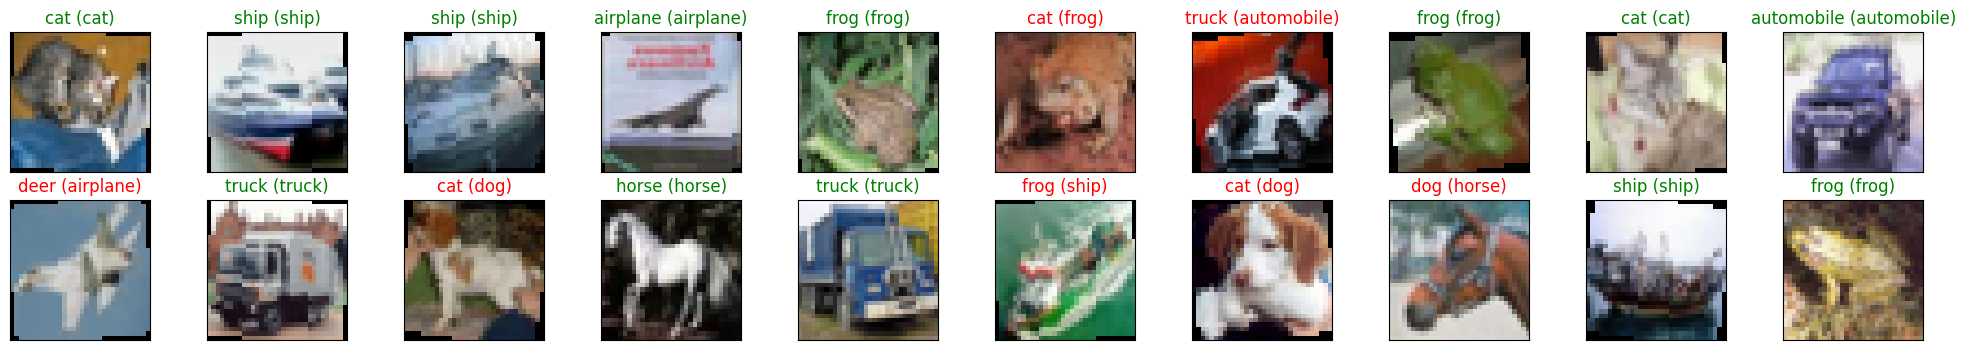

In [24]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    # Move the tensor to CPU before converting to NumPy array
    img = img.cpu()
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

Using: cuda

Files already downloaded and verified
Files already downloaded and verified


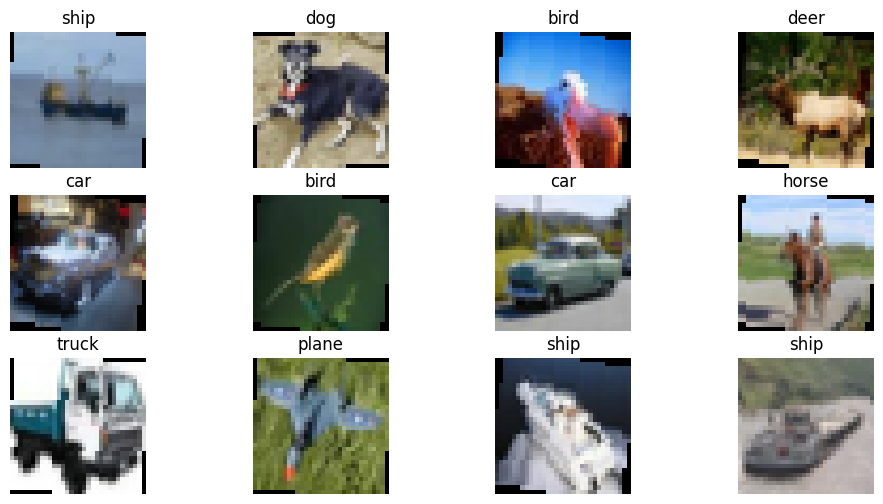

Model Architecture:
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)
Epoch 1/15
Train Loss: 1.4164 | Val Loss: 1.1839
Train Acc: 48.75% | Val Acc: 56.90%

Epoch 2/15
Train Loss: 1.0870 | Val Loss: 1.0178
Train Acc: 61.30% | Val Acc: 64.14%

Epoch 3/15
Train Loss: 0.9782 | Val Loss: 0.8898
Train Acc: 65.52% | Val Acc: 68.64%

Epoch 4/15
Train Loss: 0.8947 | Val Loss: 0.8597
Train Acc: 68.62% | Val Acc:

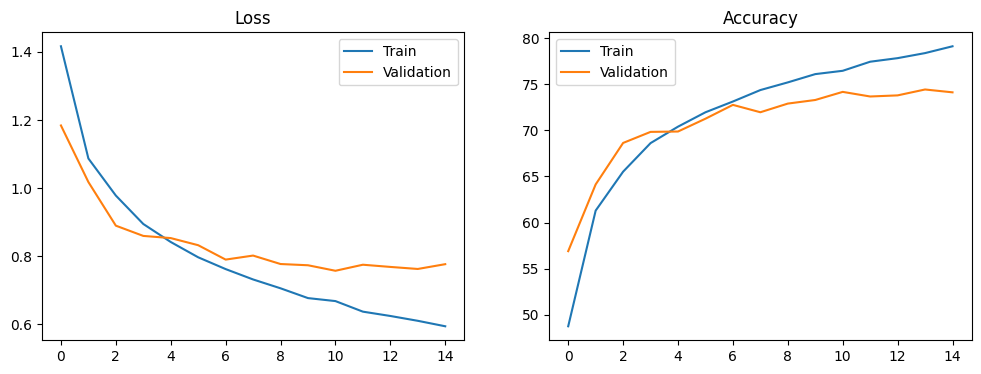

Test Accuracy: 76.59%


In [25]:
# -*- coding: utf-8 -*-
"""
CIFAR-10 CNN Tutorial (Simplified for Beginners)
Learn to classify 10 types of objects in color images!
"""

# ======================
# 1. Setup Environment
# ======================
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}\n")

# ======================
# 2. Prepare Data
# ======================
# Image transformations (preprocessing)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip images randomly
    transforms.RandomRotation(10),      # Rotate images slightly
    transforms.ToTensor(),              # Convert to tensor (0-1 range)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize colors
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
train_data = datasets.CIFAR10('data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=test_transform)

# Split training data into train/validation
from torch.utils.data import DataLoader, random_split
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

# Class labels
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# ======================
# 3. Show Sample Images
# ======================
def imshow(img):
    """Helper function to display images"""
    img = img / 2 + 0.5  # Unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

# Get one batch of training images
images, labels = next(iter(train_loader))

# Plot sample images
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    imshow(images[i])
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

# ======================
# 4. Build CNN Model
# ======================
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature extractor
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, 3, padding=1),  # (32x32x3) -> (32x32x32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # -> (16x16x32)

            # Conv Block 2
            nn.Conv2d(32, 64, 3, padding=1), # -> (16x16x64)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # -> (8x8x64)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
print("Model Architecture:")
print(model)

# ======================
# 5. Training Setup
# ======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ======================
# 6. Training Loop
# ======================
def train_model(model, num_epochs=10):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate epoch statistics
        train_loss = running_loss/len(train_loader)
        val_loss = val_running_loss/len(val_loader)
        train_accuracy = 100 * correct/total
        val_accuracy = 100 * val_correct/val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%\n")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

# Start training!
train_model(model, num_epochs=15)

# ======================
# 7. Evaluate on Test Set
# ======================
def test_model(model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

test_model(model)